In [4]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1. Spark Session

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# 2. Load Data

In [6]:
df = spark.read.csv("telecom_churn.csv", header=True, inferSchema=True)

# Show schema and preview
df.printSchema()
df.show(5)

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)

+----------+------+-------------+-------+----------+------+------------+---------

# 3. Data Cleaning

In [7]:
# Remove rows with missing or blank TotalCharges
from pyspark.sql.functions import col, trim

df = df.filter(trim(col("TotalCharges")) != "")
df = df.withColumn("TotalCharges", col("TotalCharges").cast("float"))

# Create binary label column from 'Churn'
from pyspark.sql.functions import when

df = df.withColumn("label", when(col("Churn") == "Yes", 1).otherwise(0))

# 4. Categorical & Numerical Features

In [8]:
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']

numeric_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# To display unique data in the fields

In [9]:
df.select("PaymentMethod").distinct().show()


+--------------------+
|       PaymentMethod|
+--------------------+
|Credit card (auto...|
|        Mailed check|
|Bank transfer (au...|
|    Electronic check|
+--------------------+



# 5. Feature Engineering (StringIndexer + OneHotEncoder)

In [10]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Indexing + Encoding for categorical features
indexers = [StringIndexer(inputCol=c, outputCol=c+"_Index") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=c+"_Index", outputCol=c+"_Vec") for c in categorical_cols]

# Assemble all features
feature_cols = [c + "_Vec" for c in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 6. Logistic Regression Model

In [11]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label")

# 7. Create ML Pipeline

In [12]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# 8. Train-Test Split

In [13]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

# 9. Train the Model

In [14]:
model = pipeline.fit(train_df)

# 10. Make Predictions

In [15]:
predictions = model.transform(test_df)
predictions.select("customerID", "label", "prediction", "probability").show(5)

+----------+-----+----------+--------------------+
|customerID|label|prediction|         probability|
+----------+-----+----------+--------------------+
|0004-TLHLJ|    1|       1.0|[0.35516363180839...|
|0013-SMEOE|    0|       0.0|[0.94506022886372...|
|0015-UOCOJ|    0|       0.0|[0.57800091414042...|
|0016-QLJIS|    0|       0.0|[0.98283601635121...|
|0019-EFAEP|    0|       0.0|[0.95733054169966...|
+----------+-----+----------+--------------------+
only showing top 5 rows


In [16]:
# 11. Model Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
print("AUC: ", evaluator.evaluate(predictions))

# Accuracy
acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
print("Accuracy: ", acc_evaluator.evaluate(predictions))

# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

AUC:  0.8593495509812639
Accuracy:  0.8143712574850299
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  230|
|    0|       0.0| 1329|
|    1|       1.0|  303|
|    0|       1.0|  142|
+-----+----------+-----+



In [17]:
# Convert predictions to Pandas
preds_pd = predictions.select("label", "prediction", "probability").toPandas()


In [19]:
pip install matplotlib seaborn scikit-learn

  Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl (10.7 MB)
Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:-


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


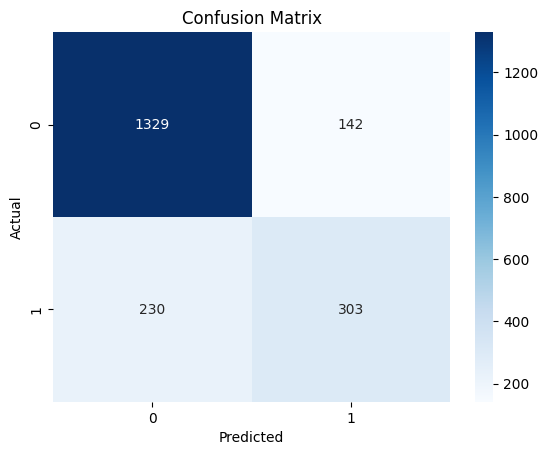

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(preds_pd["label"], preds_pd["prediction"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


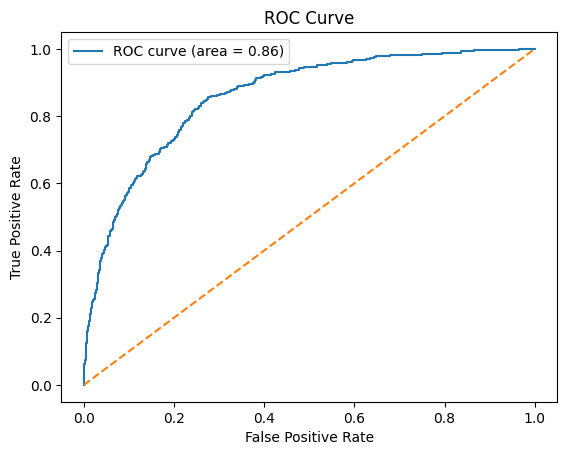

In [21]:
from sklearn.metrics import roc_curve, auc

probs = preds_pd["probability"].apply(lambda x: x[1])  # Get probability of class 1
fpr, tpr, _ = roc_curve(preds_pd["label"], probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [22]:
sample_df = df.sample(False, 0.1, seed=42)  # 10% sample
pandas_df = sample_df.toPandas()


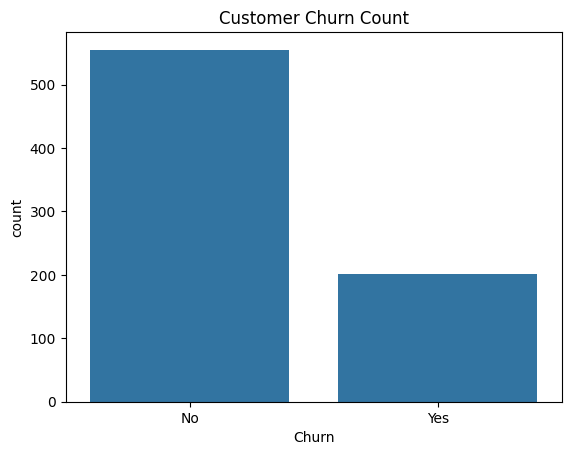

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn', data=pandas_df)
plt.title("Customer Churn Count")
plt.show()


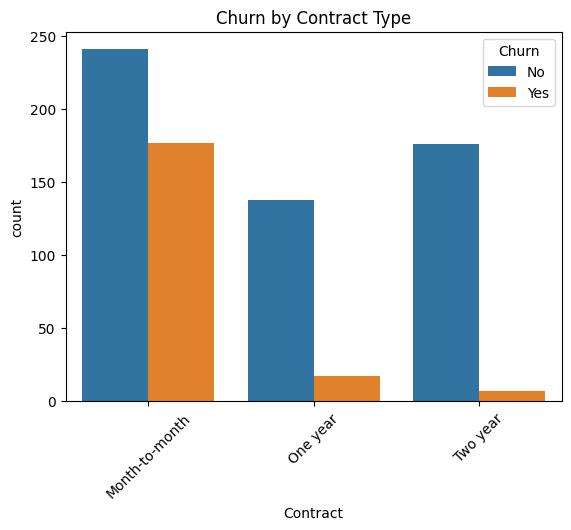

In [24]:
sns.countplot(x='Contract', hue='Churn', data=pandas_df)
plt.title("Churn by Contract Type")
plt.xticks(rotation=45)
plt.show()


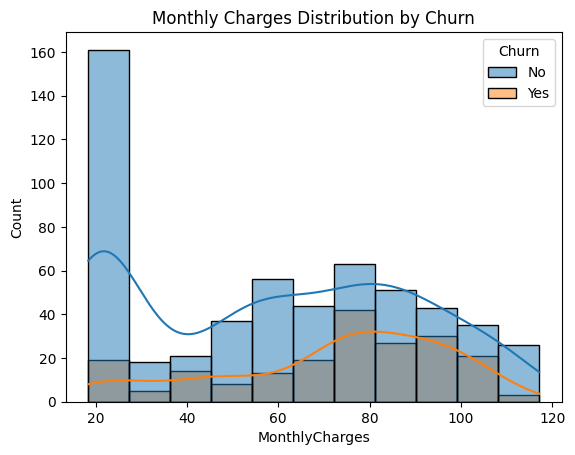

In [25]:
sns.histplot(data=pandas_df, x="MonthlyCharges", hue="Churn", kde=True)
plt.title("Monthly Charges Distribution by Churn")
plt.show()


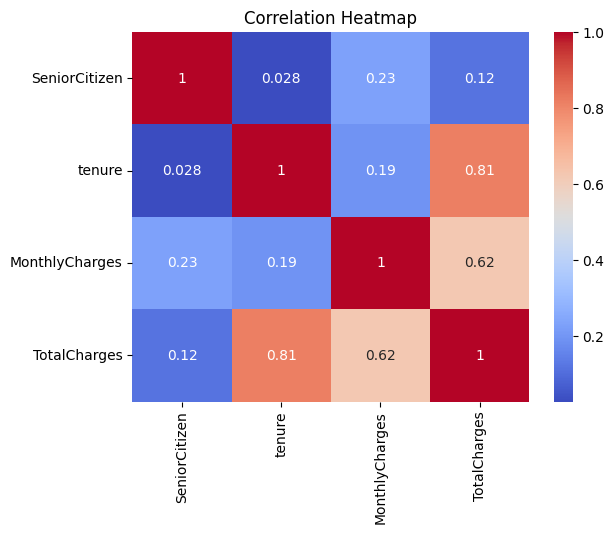

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
corr = pandas_df[num_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


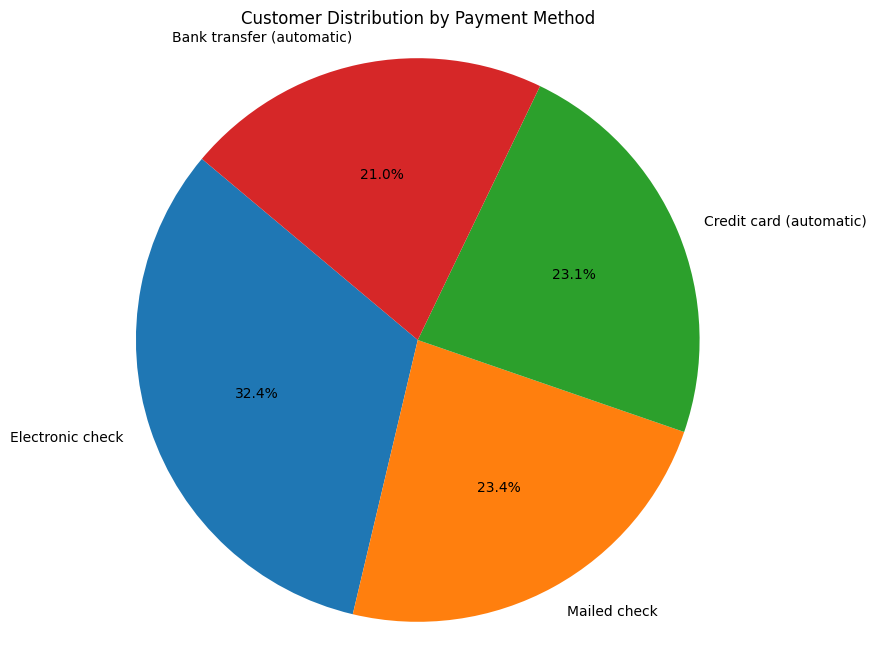

In [27]:
import matplotlib.pyplot as plt

# Count of each payment method
payment_counts = pandas_df['PaymentMethod'].value_counts()

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Distribution by Payment Method')
plt.axis('equal')
plt.show()


In [ ]:
pip install plotly

In [28]:
import plotly.express as px

fig = px.histogram(pandas_df, x="PaymentMethod", color="Churn",
                   barmode="group",
                   title="Churn by Payment Method")
fig.update_layout(xaxis_title="Payment Method", yaxis_title="Count")
fig.show()


ModuleNotFoundError: No module named 'plotly'